In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For machine learning models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# For saving/loading models
import pickle

# Load the dataset
# Make sure 'measures_v2.csv' is in the same directory as your Jupyter Notebook,
# or provide the full path to the file.
df = pd.read_csv('measures_v2.csv')

# Display the first 5 rows of the dataframe
print("--- First 5 rows of the dataset ---")
print(df.head())

# Display general information about the dataframe (data types, non-null values)
print("\n--- Dataset Information ---")
df.info()

# Display descriptive statistics of numerical columns
print("\n--- Descriptive Statistics ---")
print(df.describe())

# Check for the shape of the dataset (rows, columns)
print(f"\nDataset shape: {df.shape}")

--- First 5 rows of the dataset ---
        u_q    coolant  stator_winding       u_d  stator_tooth  motor_speed  \
0 -0.450682  18.805172       19.086670 -0.350055     18.293219     0.002866   
1 -0.325737  18.818571       19.092390 -0.305803     18.294807     0.000257   
2 -0.440864  18.828770       19.089380 -0.372503     18.294094     0.002355   
3 -0.327026  18.835567       19.083031 -0.316199     18.292541     0.006105   
4 -0.471150  18.857033       19.082525 -0.332272     18.291428     0.003133   

        i_d       i_q         pm  stator_yoke    ambient    torque  profile_id  
0  0.004419  0.000328  24.554214    18.316547  19.850691  0.187101          17  
1  0.000606 -0.000785  24.538078    18.314955  19.850672  0.245417          17  
2  0.001290  0.000386  24.544693    18.326307  19.850657  0.176615          17  
3  0.000026  0.002046  24.554018    18.330833  19.850647  0.238303          17  
4 -0.064317  0.037184  24.565397    18.326662  19.850639  0.208197          17  

--

In [2]:
# Identify target variable and features
# The problem statement specifies 'rotor temperature' as the target.
# Looking at the dataset, 'pm' is permanent magnet temperature. 'stator_winding', 'stator_tooth', 'stator_yoke'
# are other temperatures. 'motor_speed', 'torque', 'id', 'iq', 'coolant', 'u_d', 'u_q', 'i_d', 'i_q', 'psi_d', 'psi_q', 'profile_id'
# are input features.
# Let's assume 'pm' (Permanent Magnet Temperature) is the rotor temperature we need to predict based on the context.
# If 'motor_rotor_temperature' was an explicit column, we would use that.
# Given the columns, 'pm' is the most plausible rotor temperature.

# Let's check for null values
print("\n--- Missing values before handling ---")
print(df.isnull().sum())

# Drop the 'profile_id' column as it's likely an identifier and not a useful feature for prediction.
# It might also indicate different test profiles, which could be handled differently if known,
# but for a general prediction model, it's often best to remove ID-like columns.
df = df.drop('profile_id', axis=1)
print("\n'profile_id' column dropped.")

# Check for negative data in relevant columns (temperatures, speed, torque)
# It's unlikely for temperatures to be negative in Celsius in this context, or for speed/torque to be
# significantly negative unless it indicates direction, but let's check for highly unusual values.
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
for col in numerical_cols:
    negative_values_count = (df[col] < 0).sum()
    if negative_values_count > 0:
        print(f"Column '{col}' has {negative_values_count} negative values.")
        # For demonstration, let's convert negative values to their absolute value or 0 if they represent magnitudes
        # or remove rows if negative values are errors. For temperature, negative values are likely errors if not Kelvin.
        # Given the range of temperatures often seen in such datasets (e.g., 20-100 C), negative values would be outliers.
        # For simplicity, let's treat any negative values in temperature/speed/torque as anomalies and cap them at 0.
        # A more robust approach would be to investigate or remove.
        if 'temperature' in col or col in ['motor_speed', 'torque', 'i_d', 'i_q', 'u_d', 'u_q', 'psi_d', 'psi_q']:
            df[col] = df[col].apply(lambda x: max(x, 0)) # Set negative values to 0.

# Re-check for negative values after handling
print("\n--- Negative values after handling (capped at 0) ---")
for col in numerical_cols:
    if (df[col] < 0).sum() > 0:
        print(f"Column '{col}' still has negative values (this should not happen if cap to 0 was applied correctly).")

# No explicit categorical data observed in .info(), so no handling needed for now.



--- Missing values before handling ---
u_q               0
coolant           0
stator_winding    0
u_d               0
stator_tooth      0
motor_speed       0
i_d               0
i_q               0
pm                0
stator_yoke       0
ambient           0
torque            0
profile_id        0
dtype: int64

'profile_id' column dropped.
Column 'u_q' has 31656 negative values.
Column 'u_d' has 344733 negative values.
Column 'motor_speed' has 30889 negative values.
Column 'i_d' has 515656 negative values.
Column 'i_q' has 89161 negative values.
Column 'torque' has 198813 negative values.

--- Negative values after handling (capped at 0) ---



--- Univariate Analysis: Histograms ---


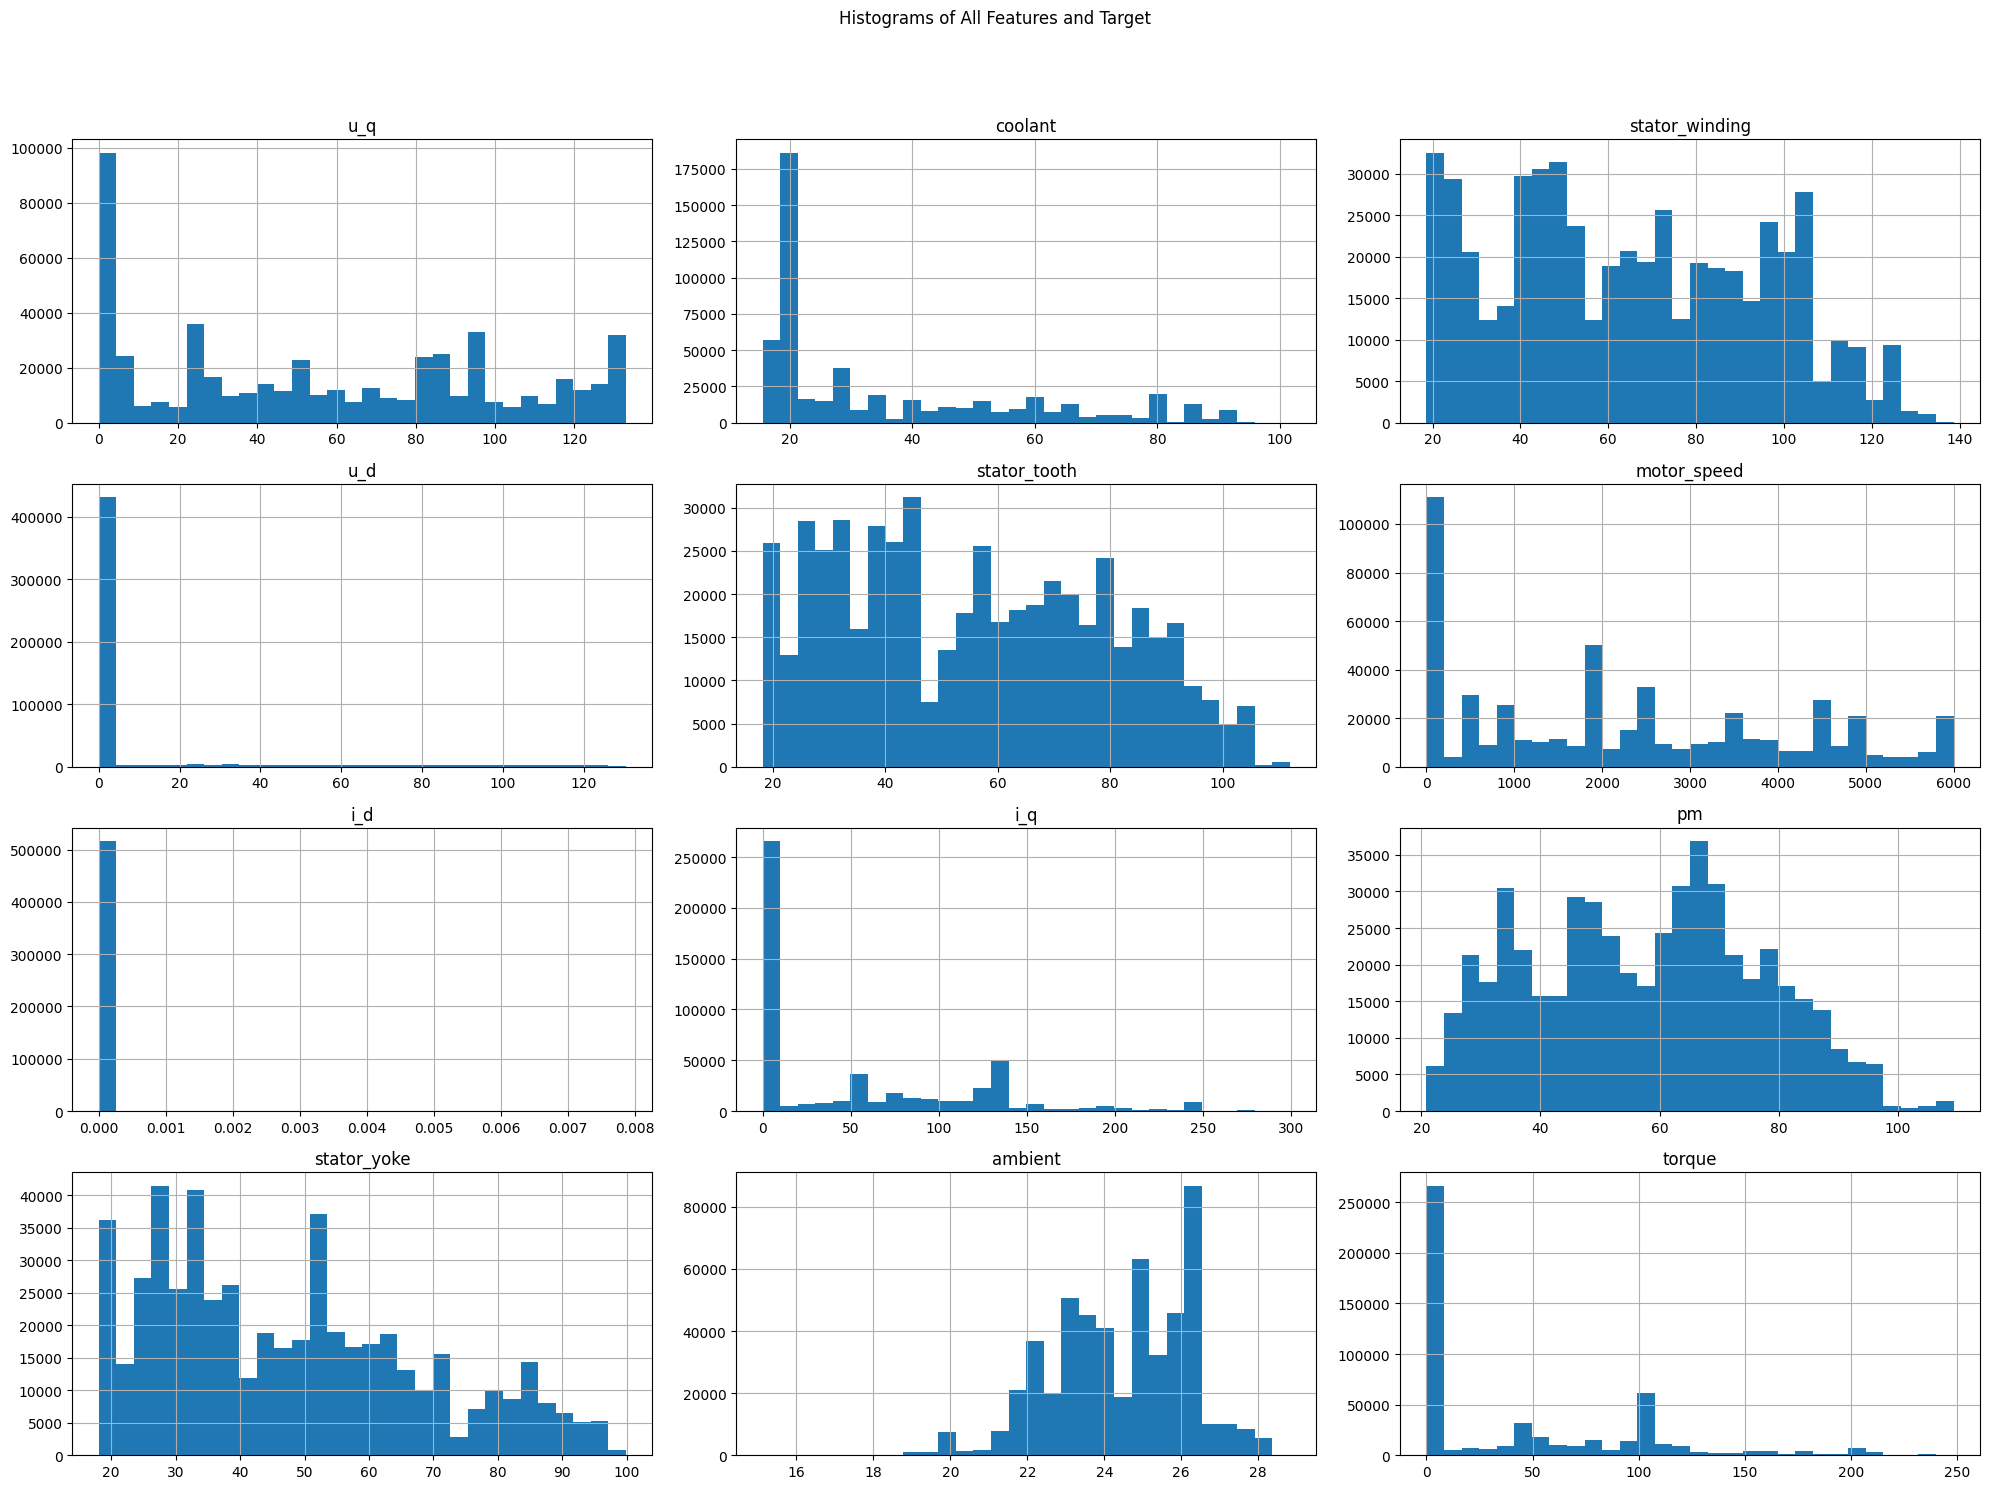


--- Univariate Analysis: Box Plots ---


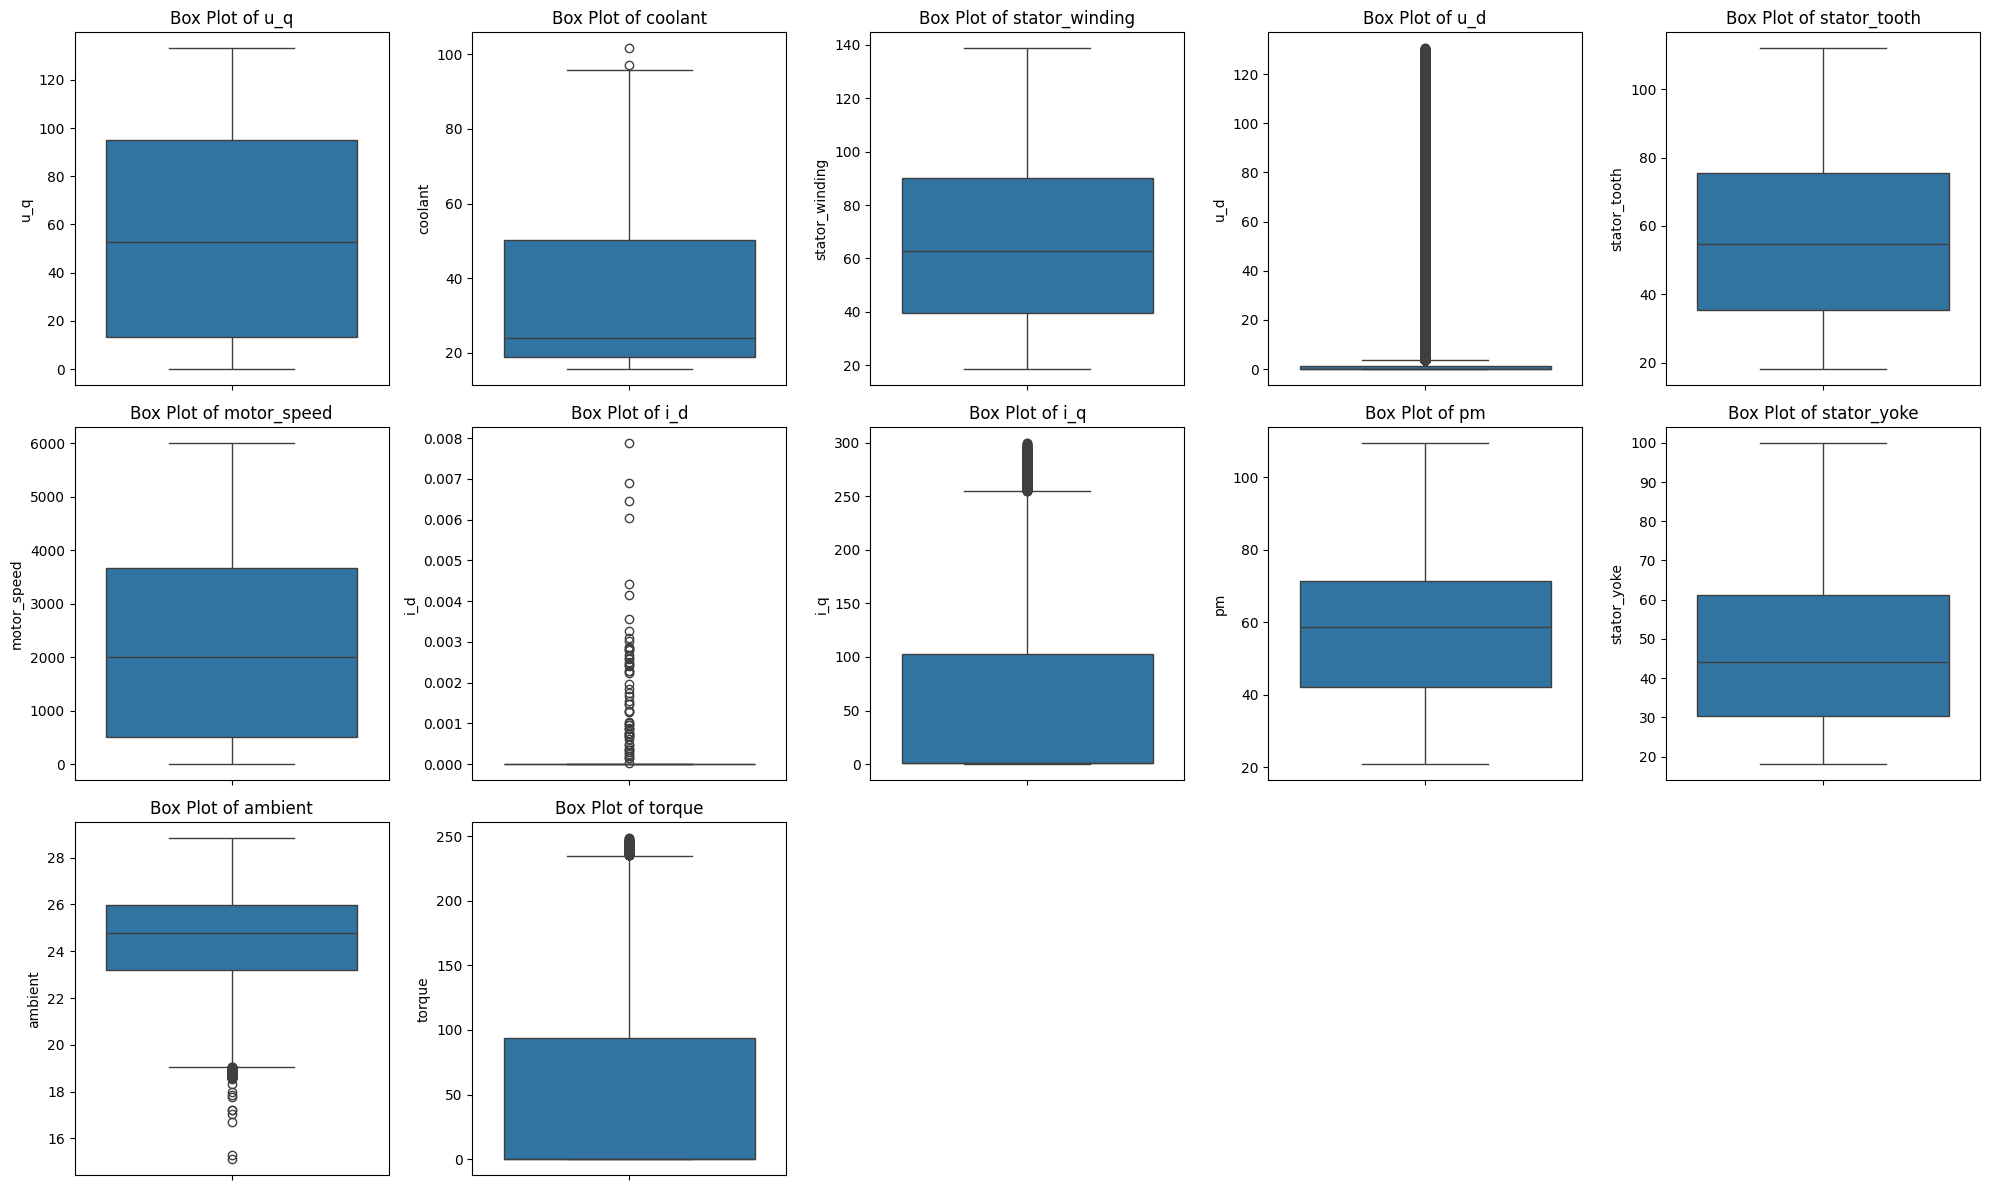


--- Multivariate Analysis: Correlation Matrix ---


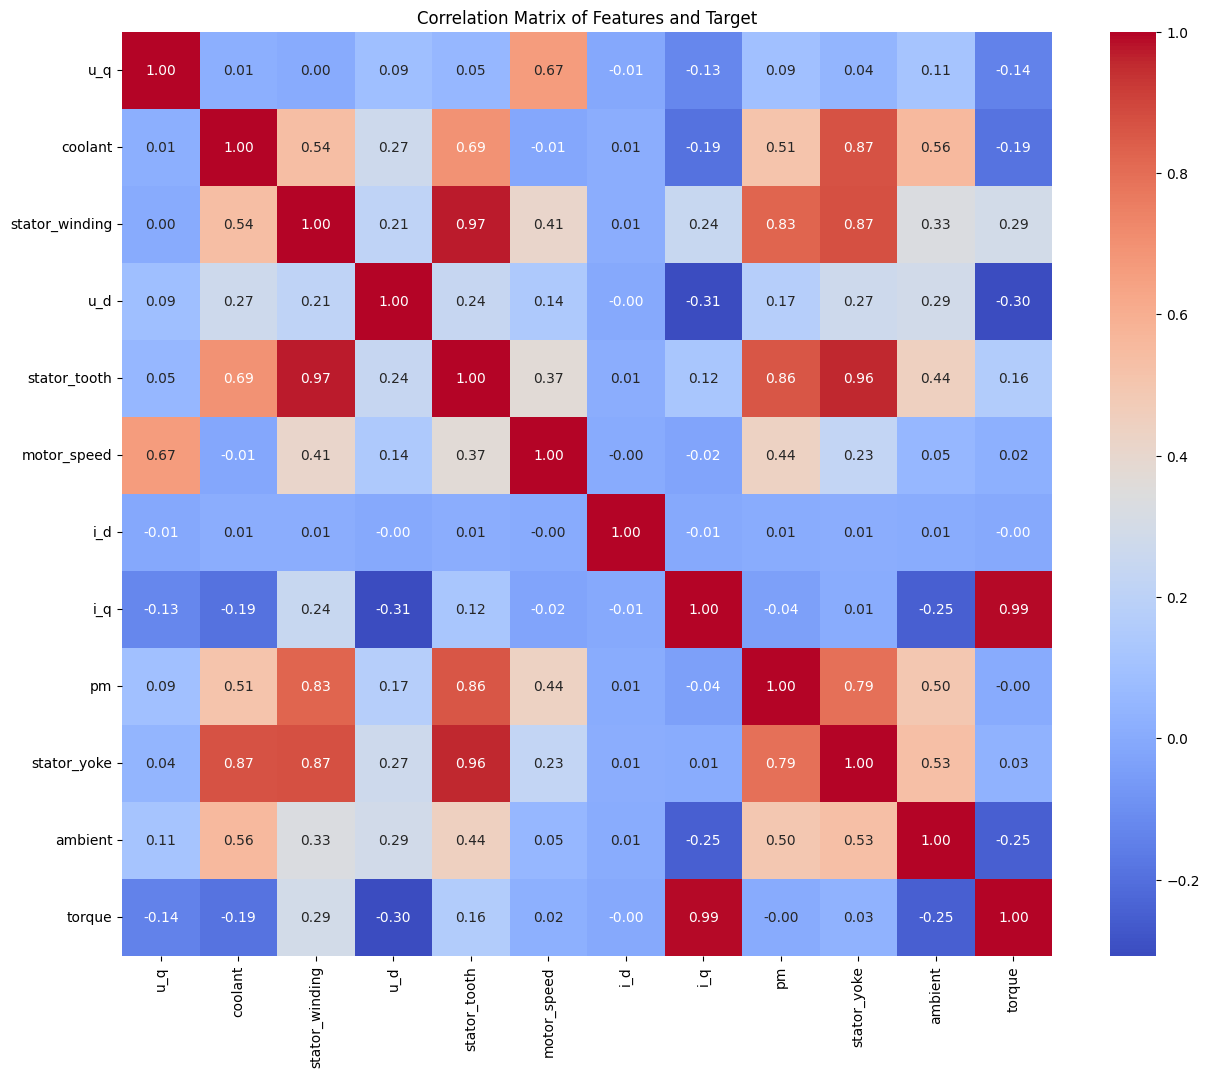


--- Top correlations with pm ---
pm                1.000000
stator_tooth      0.859491
stator_winding    0.825491
stator_yoke       0.791104
coolant           0.512556
ambient           0.496501
motor_speed       0.436961
u_d               0.174082
u_q               0.092679
i_d               0.008008
torque           -0.000947
i_q              -0.040553
Name: pm, dtype: float64

--- Scatter plots of top 5 correlated features with 'pm' ---


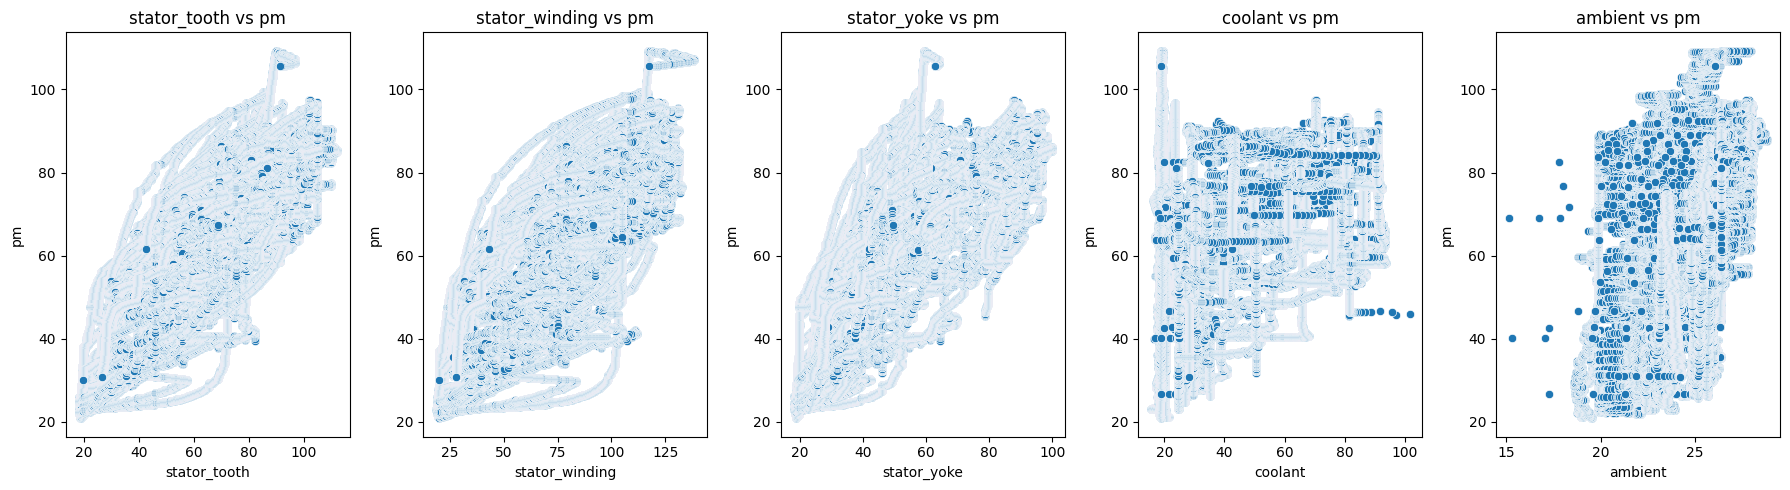

In [3]:
# Univariate Analysis (Distribution of individual features and target)
print("\n--- Univariate Analysis: Histograms ---")
df.hist(bins=30, figsize=(20, 15))
plt.suptitle("Histograms of All Features and Target", y=1.02) # Adjusted title position
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap
plt.show()

# Box plots to check for outliers (visual inspection)
print("\n--- Univariate Analysis: Box Plots ---")
# Determine number of rows/columns for subplots dynamically
num_cols = df.shape[1]
num_rows = (num_cols + 4) // 5 # Roughly 5 plots per row
plt.figure(figsize=(20, num_rows * 4)) # Adjust figure size dynamically
for i, column in enumerate(df.columns):
    plt.subplot(num_rows, 5, i + 1) # Adjust subplot grid based on number of columns
    sns.boxplot(y=df[column])
    plt.title(f'Box Plot of {column}')
plt.tight_layout()
plt.show()


# Multivariate Analysis (Relationships between features and target)
# Correlation Matrix (Numerical features)
print("\n--- Multivariate Analysis: Correlation Matrix ---")
plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features and Target")
plt.show()

# Scatter plots of highly correlated features with the target ('pm')
# Let's select top correlated features with 'pm' for scatter plots
target_col = 'pm' # Our target variable
correlations = df.corr()[target_col].sort_values(ascending=False)
print(f"\n--- Top correlations with {target_col} ---")
print(correlations)

# Plot scatter plots for top N correlated features (excluding 'pm' itself)
top_n = 5 # Number of top correlated features to plot
# Exclude the target column itself from the list of features to plot against
# We take from index 1 because index 0 will be 'pm' itself with correlation 1.0
top_correlated_features = correlations[1:top_n+1].index.tolist()

print(f"\n--- Scatter plots of top {top_n} correlated features with '{target_col}' ---")
plt.figure(figsize=(18, 5))
for i, feature in enumerate(top_correlated_features):
    plt.subplot(1, top_n, i + 1)
    sns.scatterplot(x=df[feature], y=df[target_col])
    plt.title(f'{feature} vs {target_col}')
    plt.xlabel(feature)
    plt.ylabel(target_col)
plt.tight_layout()
plt.show()

In [10]:
# Define features (X) and target (y)
target_col = 'pm' # Corrected to 'pm'
X = df.drop(columns=[target_col]) # All columns except the target
y = df[target_col] # The target column

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# --- IMPORTANT: Verify the features here ---
# This will print the list of columns that X_train contains.
# This list MUST match the 'input_features_columns' in your app.py file exactly.
print("\nColumns in X_train (features used for scaler):")
print(X_train.columns.tolist()) # This should now print 11 features
# --- End Verification ---

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled using StandardScaler.")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")


Features (X) shape: (515715, 11)
Target (y) shape: (515715,)

X_train shape: (412572, 11)
X_test shape: (103143, 11)
y_train shape: (412572,)
y_test shape: (103143,)

Columns in X_train (features used for scaler):
['u_q', 'coolant', 'stator_winding', 'u_d', 'stator_tooth', 'motor_speed', 'i_d', 'i_q', 'stator_yoke', 'ambient', 'torque']

Features scaled using StandardScaler.
X_train_scaled shape: (412572, 11)
X_test_scaled shape: (103143, 11)


In [5]:
# Initialize a dictionary to store models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVM': SVR() # Support Vector Regressor
}

# Dictionary to store evaluation metrics for each model
results = {}

print("\n--- Model Training and Evaluation ---")

for name, model in models.items():
    print(f"\nTraining {name}...")
    # Train the model with scaled training data
    model.fit(X_train_scaled, y_train)

    # Make predictions on the scaled test data
    y_pred = model.predict(X_test_scaled)

    # Evaluate the model using various regression metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse) # RMSE is often preferred as it's in the same unit as the target
    r2 = r2_score(y_test, y_pred)

    # Store the results
    results[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

    print(f"{name} Performance:")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  R-squared (R2): {r2:.4f}")

# Compare all models' performance
print("\n--- Model Comparison ---")
# Sort models by R2 score in descending order for easier comparison
sorted_results = sorted(results.items(), key=lambda item: item[1]['R2'], reverse=True)

for name, metrics in sorted_results:
    print(f"\n{name}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")

# Identify the best performing model based on R-squared (higher is better)
best_model_name = sorted_results[0][0] # The first item in sorted_results will be the best
best_model = models[best_model_name]
print(f"\nBest performing model based on R-squared: {best_model_name}")



--- Model Training and Evaluation ---

Training Linear Regression...
Linear Regression Performance:
  Mean Absolute Error (MAE): 5.0267
  Mean Squared Error (MSE): 43.6937
  Root Mean Squared Error (RMSE): 6.6101
  R-squared (R2): 0.8805

Training Decision Tree...
Decision Tree Performance:
  Mean Absolute Error (MAE): 0.1186
  Mean Squared Error (MSE): 0.4571
  Root Mean Squared Error (RMSE): 0.6761
  R-squared (R2): 0.9987

Training Random Forest...
Random Forest Performance:
  Mean Absolute Error (MAE): 0.1074
  Mean Squared Error (MSE): 0.1625
  Root Mean Squared Error (RMSE): 0.4031
  R-squared (R2): 0.9996

Training SVM...
SVM Performance:
  Mean Absolute Error (MAE): 3.1056
  Mean Squared Error (MSE): 22.6694
  Root Mean Squared Error (RMSE): 4.7612
  R-squared (R2): 0.9380

--- Model Comparison ---

Random Forest:
  MAE: 0.1074
  MSE: 0.1625
  RMSE: 0.4031
  R2: 0.9996

Decision Tree:
  MAE: 0.1186
  MSE: 0.4571
  RMSE: 0.6761
  R2: 0.9987

SVM:
  MAE: 3.1056
  MSE: 22.6694
  

In [ ]:
# Save the best model using pickle
# Ensure that 'best_model_name' and 'best_model' variables were set correctly in the previous cell.
# If you restarted your kernel or only ran part of the previous cell, you might need to re-run it fully.
model_filename = 'model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)
print(f"\nBest model '{best_model_name}' saved as '{model_filename}'")

# Save the scaler using pickle
# Ensure that the 'scaler' variable was initialized and fitted in the data splitting cell.
# If you restarted your kernel or only ran part of the previous cell, you might need to re-run it fully.
scaler_filename = 'scaler.pkl'
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)
print(f"Scaler saved as '{scaler_filename}'")